In [1]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt

## Tasks
* Implement Actor
* Implement Critic
* Implement Memory
* Loss
* Episode loop

In [2]:
def t(x): return torch.from_numpy(x).float()

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [5]:
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
        

In [6]:
env = gym.make("CartPole-v1")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [7]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
memory = Memory()
max_steps = 200

In [8]:
def train(log_probs, values, rewards, q_val, entropy):
    values = torch.stack(values)
    q_vals = np.zeros((len(rewards), 1))
    q_val = 0
    for i, r in enumerate(reversed(rewards)):
        q_val = r + gamma*q_val
        q_vals[len(rewards)-i-1] = q_val
    adv = torch.Tensor(q_vals) - values
    
    critic_loss = adv.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    actor_loss = (-torch.stack(log_probs)*adv.detach()).mean() + 0.001*entropy
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

In [15]:
steps = 0
episode_rewards = []
for i in range(20):
    done = False
    total_reward = 0
    state = env.reset()
    
    rewards = []
    log_probs = []
    values = []
    q_val = 0
    entropy = 0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        values.append(critic(t(state)))
        entropy += -(probs.mean()*probs.log()).sum()
        
        total_reward += reward
        steps += 1
        
        
        
        state = next_state
        
        
        env.render()
    
    q_val = critic(t(next_state))
    train(log_probs, values, rewards, q_val, entropy)
    episode_rewards.append(total_reward)

    # print(steps, total_reward)

/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-a06cb1466e68>", line 51, in <module>
    env.render()
  File "/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/gym/core.py", line 284, in render
    return self.env.render(mode)
  File "/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/gym/envs/classic_control/cartpole.py", line 137, in render
    return self.viewer.render(return_rgb_array = mode=='rgb_array')
  File "/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/gym/envs/classic_control/rendering.py", line 85, in render
    self.window.dispatch_events()
  File "/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/pyglet/window/cocoa/__init__.py", line 303, in dispatch_events
    NSApp = NSApplication.sharedA

KeyboardInterrupt: 

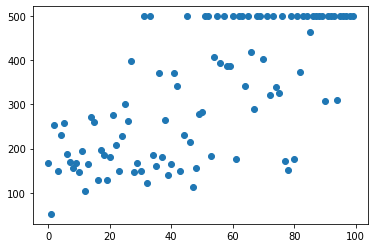

In [14]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards)